- car_evaluation 데이터셋
    - 컬럼 구성
        - price : 자동차 가격
        - maint : 자동차 유지 비용
        - doors : 자동차 문 개수
        - persons : 수용 인원
        - lug_capacity : 수하물 용량
        - safety : 안정성
        - output(종속 변수) : 차 상태
        - 아래의 범주 중 하나의 값을 가짐
        - unacc : 허용 불가능한 수준
        - acc : 허용 가능한 수준
        - good : 양호
        - vgood : 매우 좋음

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\SVT\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["KM_PDUPLICATE_LIB_OK"] = "True"

- 데이터 준비

In [3]:
dataset = pd.read_csv("./data/car_evaluation.csv")

dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [17]:
dataset.tail()

,price,maint,doors,persons,lug_capacity,safety,output
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good
1727,low,low,5more,more,big,high,vgood


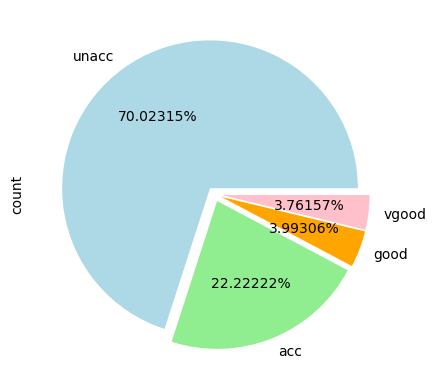

In [4]:
# 종속변수 비율
dataset["output"].value_counts().plot(kind = "pie", autopct = "%0.05f%%",
                                     colors = ["lightblue", "lightgreen", "orange", "pink"],
                                     explode = [0.05, 0.05, 0.05, 0.05])
plt.show()

In [5]:
# 데이터를 범주형 타입으로 변환
categorical_columns = ["price", "maint", "doors", "persons", "lug_capacity", "safety"]

In [6]:
# astype() 매서드를 이용하여 데이터를 범주형으로 변환
for category in categorical_columns:
    dataset[category] = dataset[category].astype("category")

- 범주형 데이터를 텐서로 변환하기 위한 절차
    - 범주형 데이터 -> astype("category") -> numpy 배열 ->  텐서

In [7]:
# 범주형 데이터를 넘파이 배열로 변환
price = dataset["price"].cat.codes.values
maint = dataset["maint"].cat.codes.values
doors= dataset["doors"].cat.codes.values
persons = dataset["persons"].cat.codes.values
lug_capacity = dataset["lug_capacity"].cat.codes.values
safety = dataset["safety"].cat.codes.values

In [18]:
categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [19]:
# 레이블로 사용할 컬럼을 텐서로 변환 
outputs = pd.get_dummies(dataset["output"]) # 원핫인코딩
outputs = outputs.values # 넘파이배열로 변경
outputs = torch.tensor(outputs).flatten()
outputs

tensor([False, False,  True,  ..., False, False,  True])

In [20]:
categorical_data.shape

(1728, 6)

In [21]:
outputs.shape

torch.Size([6912])

In [22]:
# 각 범주 간의 세부적인 관계를 잘 파악하기 위해 임베딩
# 임베딩 크기는 각 컬럼의 고유값 수 나누기 2로 임의 사용
categorical_columns_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size * 1)//2)) for col_size in categorical_columns_sizes]

# 모든 범주형 컬럼의 고유값 수, 차원의 크기
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 1), (3, 1), (3, 1)]


- 데이터 분할

In [23]:
# 데이터셋 분리(8:2)
total_records = categorical_data.shape[0]
test_records = int(total_records * 0.2)

In [24]:
total_records, test_records

(1728, 345)

In [25]:
categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records : total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records : total_records]

In [26]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


- 모델 생성

In [27]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p = 0.4):
        '''
        모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도
        객체가 생성될 때 자동으로 호출됨
        
        embedding_size : 범주형 컬럼의 임베딩 크기
        output_size : 출력층의 크기
        layers : 모든 계층에 대한 목록
        p : 드롭아웃(기본값 0.4)
        '''
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols
        
        for i in layers:
            # 전결합층
            all_layers.append(nn.Linear(input_size, i))
            # 활성화 함수
            all_layers.append(nn.ReLU(inplace = True))
            # 배치 정규화
            # 신경망 안에서 데이터의 평균과 분산을 조정
            all_layers.append(nn.BatchNorm1d(i))
            # 드롭아웃
            all_layers.append(nn.Dropout(p))
            input_size = i
            
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_categorical):
        '''
        학습 데이터를 입력받아서 연산을 진행
        모델 객체를 데이터와 함께 호출하면 자동으로 실행
        '''
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x 

In [28]:
# Model 객체 생성
# (범주형 컬럼의 임베딩 크기, 출력 크기, 은닉층의 유닛, 드롭아웃)
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p = 0.4)
model

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 1)
    (4): Embedding(3, 1)
    (5): Embedding(3, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)

- 모델 파라미터 정의
    - 손실 함수와 옵티마이저 정의

In [29]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [30]:
# cpu/gpu 지정
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [31]:
device

device(type='cuda')

In [37]:
# device 세팅 & 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

categorical_train_data = torch.as_tensor(categorical_train_data, dtype=torch.long, device=device)

train_outputs = torch.as_tensor(train_outputs, dtype=torch.long, device=device)


In [38]:
epochs = 500
aggregated_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()

    y_pred = model(categorical_train_data)     # [N, C]
    loss = loss_function(y_pred, train_outputs)  # CrossEntropyLoss 권장
    loss.backward()
    optimizer.step()

    aggregated_losses.append(loss.item())  # 텐서 대신 수치 저장

    if epoch % 25 == 1:
        print(f"epoch: {epoch:3} | loss: {loss.item():.8f}")

print(f"epoch: {epoch:3} | loss: {loss.item():.8f}")



epoch:   1 | loss: 1.64275753
epoch:  26 | loss: 1.44769657
epoch:  51 | loss: 1.34091830
epoch:  76 | loss: 1.20724773
epoch: 101 | loss: 1.10855842
epoch: 126 | loss: 0.95450819
epoch: 151 | loss: 0.83543044
epoch: 176 | loss: 0.75721586
epoch: 201 | loss: 0.70938170
epoch: 226 | loss: 0.66267884
epoch: 251 | loss: 0.64631593
epoch: 276 | loss: 0.62186164
epoch: 301 | loss: 0.59937382
epoch: 326 | loss: 0.60727990
epoch: 351 | loss: 0.59737504
epoch: 376 | loss: 0.58829862
epoch: 401 | loss: 0.58786708
epoch: 426 | loss: 0.58584380
epoch: 451 | loss: 0.58938944
epoch: 476 | loss: 0.58368224
epoch: 500 | loss: 0.57928455


- 테스트 데이터셋으로 모델 예측

In [40]:
import torch
import numpy as np

# 0) 디바이스 & 모델
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 1) NumPy/판다스 → Tensor 변환 (임베딩 입력은 Long!)
if not isinstance(categorical_test_data, torch.Tensor):
    # pandas DataFrame이라면 categorical_test_data.values로 바꿔주세요.
    categorical_test_data = torch.as_tensor(
        np.asarray(categorical_test_data), dtype=torch.long, device=device
    )
else:
    categorical_test_data = categorical_test_data.to(device=device, dtype=torch.long)

# 라벨도 Long (CrossEntropyLoss 기준)
if not isinstance(test_outputs, torch.Tensor):
    test_outputs = torch.as_tensor(test_outputs, dtype=torch.long, device=device)
else:
    test_outputs = test_outputs.to(device=device, dtype=torch.long)

# 2) 평가
with torch.no_grad():
    y_val = model(categorical_test_data)      # [N, C] logits
    loss = loss_function(y_val, test_outputs) # CrossEntropyLoss 등
print(f"Loss: {loss.item():.8f}")


Loss: 0.56833029
